<a href="https://colab.research.google.com/github/chien2734/sgu_data_analyst/blob/chien/Lab03_BuiDucChien_3122410039.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Phân loại nguy cơ Tiểu đường — Pima Indians


# **Bài làm**

## 1. Định nghĩa vấn đề (Define Problem)
+ **Mô tả:**
  + Dùng bộ dữ liệu Pima Indians để dự đoán xem một phụ nữ Pima (≥21 tuổi) có **mắc tiểu đường trong 5 năm** (Outcome = 1) hay không (Outcome = 0)
  + Bộ dữ liệu gồm 768 mẫu
+ Dữ liệu vào:
  + Pregnancies: số lần mang thai
  + Glucose: nồng độ glucose huyết tương sau 2 giờ (OGTT) (mg/dL)
  + BloodPressure: huyết áp tâm trương (mm Hg)
  + SkinThickness: độ dày nếp gấp da (mm)
  + Insulin: nồng độ insulin sau 2 giờ (μU/ml)
  + BMI: body mass index (kg/m²)
  + DiabetesPedigreeFunction (DPF): chỉ số phả hệ tiểu đường
  + Age: tuổi (năm)
+ Kết quả:
  + Outcome: 0 = không mắc bệnh trong 5 năm
  + Outcome: 1 = mắc bệnh trong 5 năm

## 2. Chuẩn bị vấn đề (Prepare Problem)

### 2.1. Khai báo thư viện (Load Libraries)

In [59]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

### 2.2. Nạp dữ liệu (Load Dataset)

In [4]:
# Load dataset
data_path = 'pima-indians-diabetes.csv'
data_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']
df_dataset = pd.read_csv(data_path, names = data_names)

## 3. Phân tích dữ liệu (Analyze Data)


### 3.1. Thống kê mô tả (Descriptive Statistics)

#### (1) **Hiển thị một số thông tin về dữ liệu**
+ Số dòng, số cột của dữ liệu
+ Kiểu dữ liệu của từng cột
+ 5 dòng đầu và 5 dòng cuối của bảng dữ liệu
+ Thông tin chung về dữ liệu

In [5]:
# shape
print(f'+ Shape: {df_dataset.shape}')
# types
print(f'+ Data Types: \n{df_dataset.dtypes}')
# head, tail
print(f'+ Contents: ')
print(df_dataset.head(5))
print(df_dataset.tail(5))
# info
df_dataset.info()

+ Shape: (768, 9)
+ Data Types: 
Pregnancies        int64
Glucose            int64
BloodPressure      int64
SkinThickness      int64
Insulin            int64
BMI              float64
DPF              float64
Age                int64
Outcome            int64
dtype: object
+ Contents: 
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
0            6      148             72             35        0  33.6  0.627   
1            1       85             66             29        0  26.6  0.351   
2            8      183             64              0        0  23.3  0.672   
3            1       89             66             23       94  28.1  0.167   
4            0      137             40             35      168  43.1  2.288   

   Age  Outcome  
0   50        1  
1   31        0  
2   32        1  
3   21        0  
4   33        1  
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
763           10      101             76           

**Nhận xét:**
  + Tổng số dòng dữ liệu là 768 dòng
  + Giá trị của 8 tính chất được tính với các đơn vị đo khác nhau
  + Tính chất để phân lớp là biến Outcome với 2 giá trị 0 (không mắc bệnh) và 1 (có mắc bệnh)

#### (2) **Kiểm tra tính toàn vẹn của dữ liệu**
+ Dữ liệu có bị trùng lặp không? Hiển thị dòng bị vi phạm.
+ Dữ liệu có tồn tại giá trị Null, NaN không? Hiển thị dòng bị vi phạm.
+ Đặc biệt: các giá trị bằng 0 ở Glucose, BloodPressure, SkinThickness, Insulin, BMI cần cân nhắc (vì sinh học không thể bằng 0).

In [6]:
has_null = df_dataset.isnull().sum().any()
has_nan  = df_dataset.isna().sum().any()
n_duplicated = df_dataset.duplicated().sum()

print(f'Tính toàn vẹn dữ liệu:')
print(f'+ Có giá trị Null: {has_null}')
if has_null:
    print(df_dataset[df_dataset.isnull().any(axis=1)])
print(f'+ Có giá trị Nan: {has_nan}')
if has_nan:
    print(df_dataset[df_dataset.isna().any(axis=1)])
print(f'+ Số dòng trùng: {n_duplicated}')

# Kiểm tra số lượng giá trị 0 ở các cột mà 0 là vô lý
print('Số lượng các giá trị 0 ở các cột:')
cols_zero_invalid = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
print((df_dataset[cols_zero_invalid] == 0).sum())

Tính toàn vẹn dữ liệu:
+ Có giá trị Null: False
+ Có giá trị Nan: False
+ Số dòng trùng: 0
Số lượng các giá trị 0 ở các cột:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


**Nhận xét:**
+ Dữ liệu không có giá trị rỗng (Null, NaN)
+ Dữ liệu không bị trùng lặp
+ Chúng ta có thể loại bỏ các hàng có giá trị bằng 0 ở các cột **Glucose, BloodPressure** hoặc **BMI** vì những hàng này chỉ chiếm khoảng **6%** dữ liệu.
+ Trong khi đó, với cột **SkinThickness**, chúng ta nên ước lượng và điền giá trị (**impute**) thay vì loại bỏ, vì nếu bỏ đi thì sẽ mất khoảng **30%** dữ liệu, gây ảnh hưởng lớn đến phân tích.

#### (3) **Các tính chất thống kê trên dữ liệu số**
+ Count, Mean, Standard Deviation, Minimum Value
+ 25th Percentile, 50th Percentile (Median), 75th Percentile, Maximum Value

In [7]:
description = df_dataset.describe().T
print(description)

               count        mean         std     min       25%       50%  \
Pregnancies    768.0    3.845052    3.369578   0.000   1.00000    3.0000   
Glucose        768.0  120.894531   31.972618   0.000  99.00000  117.0000   
BloodPressure  768.0   69.105469   19.355807   0.000  62.00000   72.0000   
SkinThickness  768.0   20.536458   15.952218   0.000   0.00000   23.0000   
Insulin        768.0   79.799479  115.244002   0.000   0.00000   30.5000   
BMI            768.0   31.992578    7.884160   0.000  27.30000   32.0000   
DPF            768.0    0.471876    0.331329   0.078   0.24375    0.3725   
Age            768.0   33.240885   11.760232  21.000  24.00000   29.0000   
Outcome        768.0    0.348958    0.476951   0.000   0.00000    0.0000   

                     75%     max  
Pregnancies      6.00000   17.00  
Glucose        140.25000  199.00  
BloodPressure   80.00000  122.00  
SkinThickness   32.00000   99.00  
Insulin        127.25000  846.00  
BMI             36.60000   67

**Nhận xét:**
  + Glucose > 0 (thường 50–250 mg/dl).
  + BloodPressure 40–200 mmHg.
  + BMI > 10 và < 70 (BMI cực lớn là hiếm).
  + Age > 20 và < 100.
  + Outcome chỉ có 0 hoặc 1.

#### (4) **Tần số xuất hiện (Distribution) trên dữ liệu phân lớp (Class) và dữ liệu danh mục (Category)**

Đối với bài toán phân lớp (classification problem), chúng ta cần tính số lần xuất hiện của thuộc tính phân lớp. Điều này là cần thiết cho vấn đề mất cân bằng (highly imbalanced problems) giữa các lớp nhằm cần xử lý đặc biệt trong bước chuẩn bị dữ liệu.

In [8]:
df_dataset["Outcome"].value_counts()

,count
Outcome,
0,500
1,268


**Nhận xét:**
  + Dữ liệu cần phân loại là người mắc bệnh **(1)** và người không mắc bệnh **(0)**
  +  Tỉ lệ chênh lệch giữa người không mắc bệnh/ người mắc bệnh là: **500/268**  

#### (5) **Mối tương quan giữa các tính chất (Correlations)**

Sự tương quan (correlation) đề cập đến mối quan hệ giữa hai biến và cách chúng có thể có hoặc không cùng nhau thay đổi.

Phương pháp phổ biến nhất để tính toán tương quan là Pearson's Correlation Coeficient, giả định có một phân phối chuẩn của các thuộc tính liên quan. Tương quan -1 hoặc 1 cho thấy mối tương quan âm hoặc dương đầy đủ tương ứng. Trong khi giá trị 0 hiển thị không tương quan ở tất cả.

$$
r = \frac{\sum_{i=1}^n{\left(x_i - \hat{x}\right)\left(y_i - \hat{y}\right)}}{\sqrt{\sum_{i=1}^n{\left(x_i - \hat{x}\right)^2}\sum_{i=1}^n{\left(y_i - \hat{y}\right)^2}}}
$$

Một số thuật toán học máy như hồi quy tuyến tính và logistic có hiệu suất kém nếu có các thuộc tính tương quan cao trong tập dữ liệu của bạn.

Như vậy, thật sự cần thiết để xem xét tất cả các mối tương quan theo cặp của các thuộc tính trong tập dữ liệu.

In [9]:
corr = df_dataset.corr(method='pearson')
print(corr)


               Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Pregnancies       1.000000  0.129459       0.141282      -0.081672 -0.073535   
Glucose           0.129459  1.000000       0.152590       0.057328  0.331357   
BloodPressure     0.141282  0.152590       1.000000       0.207371  0.088933   
SkinThickness    -0.081672  0.057328       0.207371       1.000000  0.436783   
Insulin          -0.073535  0.331357       0.088933       0.436783  1.000000   
BMI               0.017683  0.221071       0.281805       0.392573  0.197859   
DPF              -0.033523  0.137337       0.041265       0.183928  0.185071   
Age               0.544341  0.263514       0.239528      -0.113970 -0.042163   
Outcome           0.221898  0.466581       0.065068       0.074752  0.130548   

                    BMI       DPF       Age   Outcome  
Pregnancies    0.017683 -0.033523  0.544341  0.221898  
Glucose        0.221071  0.137337  0.263514  0.466581  
BloodPressure  0.281805  0.0412

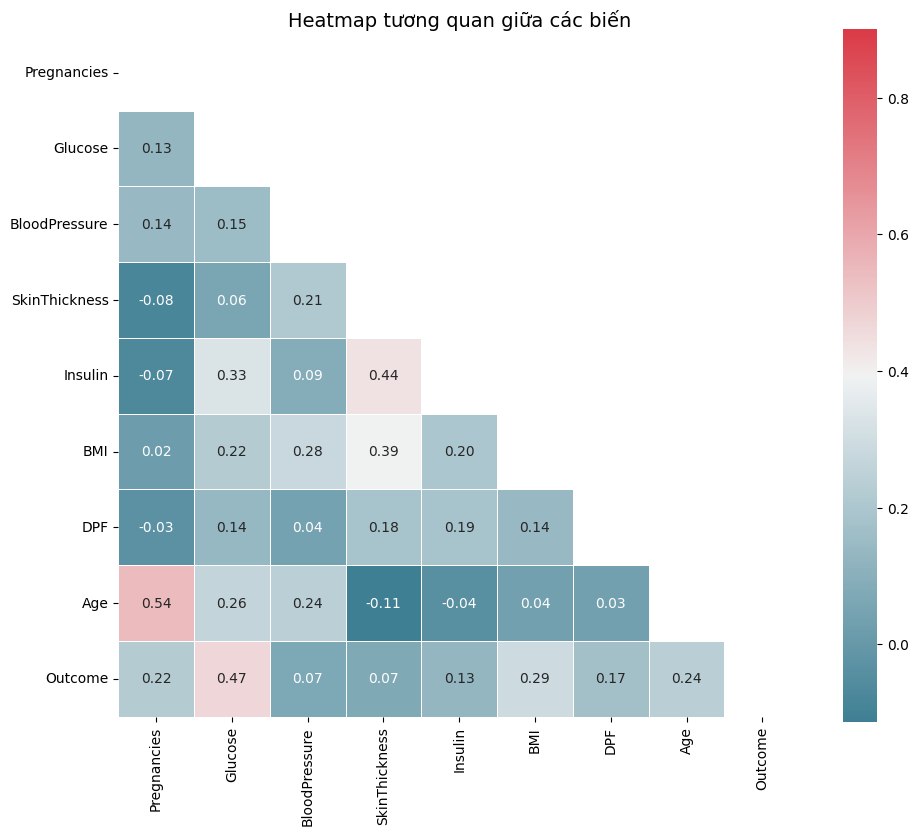

<Figure size 640x480 with 0 Axes>

In [10]:
# Tạo mask cho tam giác trên (để không lặp lại giá trị)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Tạo figure
f, ax = plt.subplots(figsize=(11, 9))

# Tạo colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Vẽ heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, square=True,
            linewidths=.5, annot=True, fmt=".2f", ax=ax)

plt.title("Heatmap tương quan giữa các biến", fontsize=14)
plt.show()
plt.savefig('heatmap.png')

**Nhận xét ma trận tương quan:**

  + **Glucose** (0.47) có tương quan mạnh nhất với Outcome → yếu tố dự báo chính.

  + **BMI** (0.29), **Age** (0.24), **Pregnancies** (0.22) cũng có liên hệ đáng kể → yếu tố nguy cơ quan trọng.

  + **DPF** (0.17), **Insulin** (0.13), **SkinThickness** (0.07), **BloodPressure** (0.06) tương quan yếu → chỉ mang tính bổ trợ.

+ Quan hệ giữa predictors: **Age–Pregnancies** (0.54), **SkinThickness–Insulin** (0.44), **SkinThickness–BMI** (0.39), **Glucose–Insulin** (0.33) → đều hợp lý về sinh học.

+ Không có đa cộng tuyến nghiêm trọng (tương quan giữa predictors < 0.8).

#### (6) **EDA mở rộng**

##### Thống kê mô tả phân tách theo Outcome

In [69]:
stats_by_outcome = df_dataset.groupby("Outcome").agg(["mean", "median", "std"])
stats_by_outcome.T   # transpose để dễ đọc (cột là Outcome)

Outcome                        0           1
Pregnancies   mean      3.298000    4.865672
              median    2.000000    4.000000
              std       3.017185    3.741239
Glucose       mean    109.980000  141.257463
              median  107.000000  140.000000
              std      26.141200   31.939622
BloodPressure mean     68.184000   70.824627
              median   70.000000   74.000000
              std      18.063075   21.491812
SkinThickness mean     19.664000   22.164179
              median   21.000000   27.000000
              std      14.889947   17.679711
Insulin       mean     68.792000  100.335821
              median   39.000000    0.000000
              std      98.865289  138.689125
BMI           mean     30.304200   35.142537
              median   30.050000   34.250000
              std       7.689855    7.262967
DPF           mean      0.429734    0.550500
              median    0.336000    0.449000
              std       0.299085    0.372354
Age           mean     31.190000   37.067164
              median   27.000000   36.000000
              std      11.667655   10.968254

Bảng này cho thấy sự khác biệt trung bình (mean), trung vị (median), và độ lệch chuẩn (std) giữa nhóm tiểu đường và không tiểu đường.

**Nhận xét:**
+ Các biến Glucose, BMI, Age, Pregnancies, DPF có sự khác biệt rõ rệt giữa hai nhóm → nhiều khả năng là các predictor mạnh.

+ Insulin có dữ liệu chưa sạch (median = 0 ở nhóm tiểu đường) → cần cẩn trọng.

+ BloodPressure và SkinThickness ít khác biệt hơn, có thể ảnh hưởng nhưng không mạnh.

##### Violin plot / KDE plot

So sánh phân bố Glucose, BMI, Age giữa nhóm tiểu đường và không tiểu đường.

/tmp/ipython-input-919285203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Outcome", y=col, data=df_dataset, palette="Set2")
/tmp/ipython-input-919285203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Outcome", y=col, data=df_dataset, palette="Set2")
/tmp/ipython-input-919285203.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Outcome", y=col, data=df_dataset, palette="Set2")


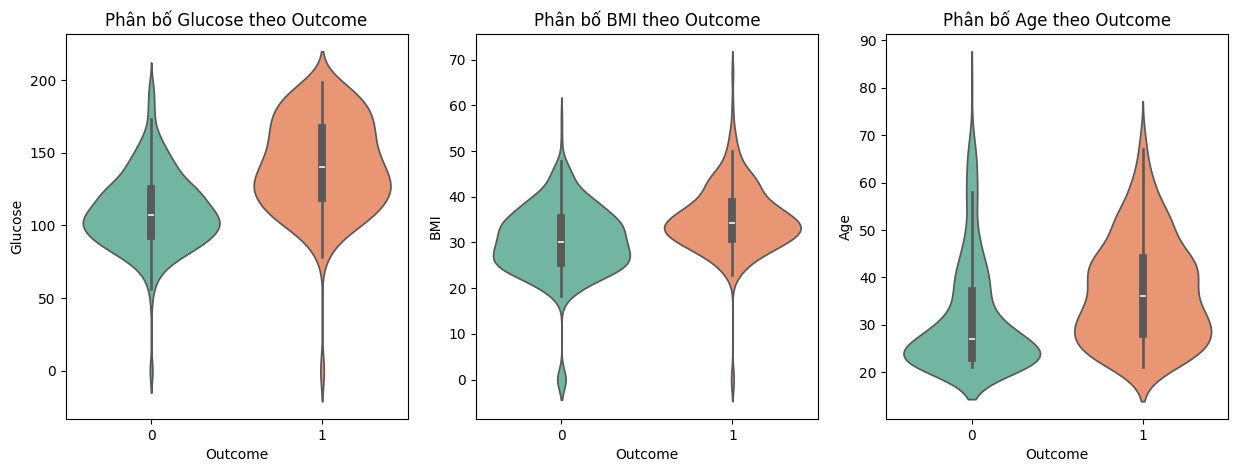

<Figure size 640x480 with 0 Axes>

In [71]:
plt.figure(figsize=(15, 5))
for i, col in enumerate(["Glucose", "BMI", "Age"], 1):
    plt.subplot(1, 3, i)
    sns.violinplot(x="Outcome", y=col, data=df_dataset, palette="Set2")
    plt.title(f"Phân bố {col} theo Outcome")
plt.show()
plt.savefig('violin.png')

**Nhận xét:**
+ Glucose là đặc trưng mạnh nhất để phân biệt hai nhóm.

+ BMI và Age cũng thể hiện sự khác biệt, đóng vai trò là yếu tố nguy cơ bổ sung.

+ Kết quả này phù hợp với hiểu biết lâm sàng từ các paper (WHO 1999, Pima dataset).

### 3.2. Hiển thị dữ liệu (Visualize Data)

#### (1) Hiển thị trên từng tính chất đơn (Univariate Plots)
**Box and whisker plots**

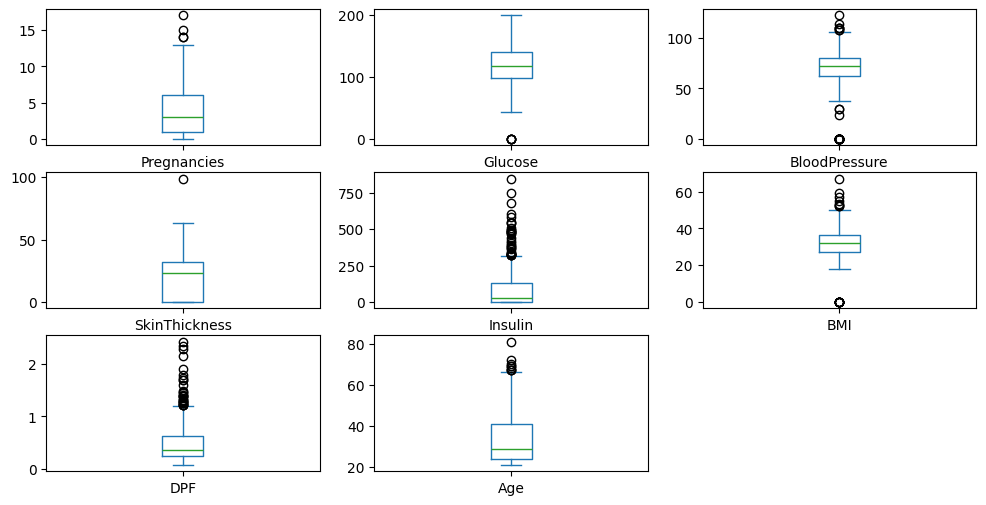

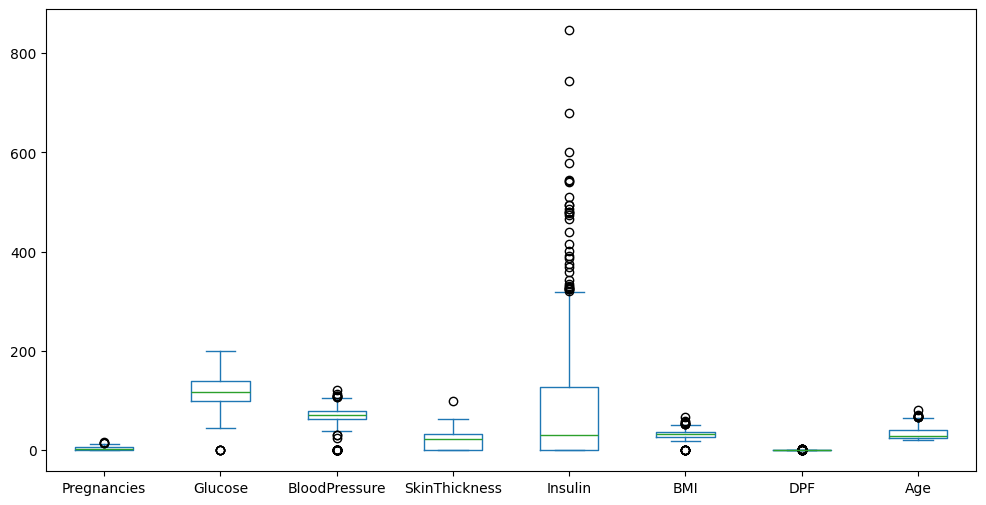

In [11]:
cols = df_dataset.columns[:-1]  # bỏ cột Outcome
df_dataset[cols].plot(kind="box", subplots=True, layout=(3, 3), sharex=False, sharey=False, figsize=(12,6));
df_dataset[cols].plot(kind="box", figsize=(12,6));

**Biểu đồ Histogram**

  Chúng ta có thể quan sát kỹ hơn mối quan hệ giữa Outcome và các biến dự đoán bằng cách sử dụng biểu đồ histogram như dưới đây. Ở mỗi biểu đồ, phần thứ nhất biểu diễn nhóm Outcome = 0 (không mắc tiểu đường), còn phần thứ hai biểu diễn nhóm Outcome = 1 (mắc tiểu đường).

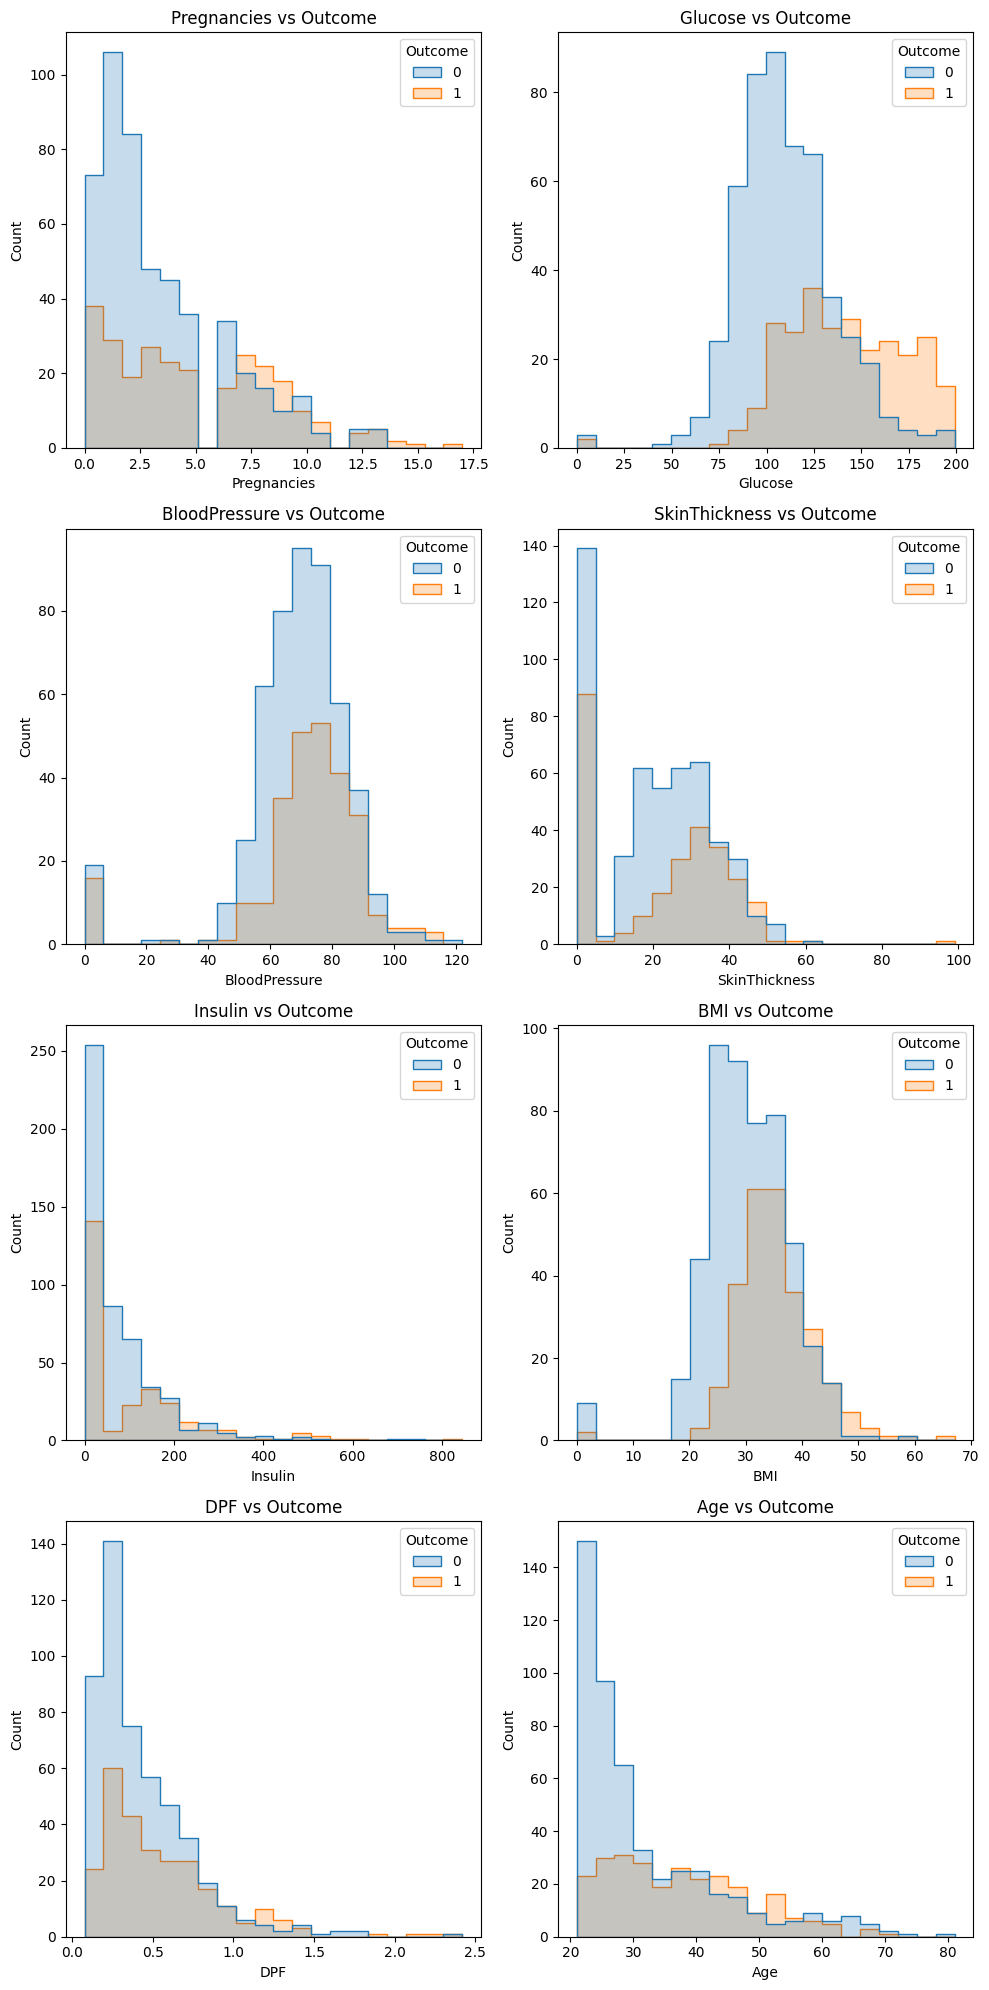

In [12]:
plt.figure(figsize=(10, 20))

for i, col in enumerate(cols, 1):
    plt.subplot(4, 2, i)
    sns.histplot(data=df_dataset, x=col, hue="Outcome", bins=20, kde=False, element="step")
    plt.title(f"{col} vs Outcome")

plt.tight_layout()
plt.show()

**Nhận xét:**
+ Số lần mang thai trung bình ở nhóm Outcome = 1 (mắc tiểu đường) dường như cao hơn.
+ Những người mắc tiểu đường thường có chỉ số **glucose** cao hơn, trong khi những người bình thường thì **glucose** trong khoảng **90-100**.
+ Xu hướng của **BloodPressure** trông giống nhau ở cả nhóm mắc tiểu đường và không mắc tiểu đường.
+ **SkinThickness** trung bình của những người mắc tiểu đường có vẻ cao hơn một chút so với những người không mắc tiểu đường.
+ Mức **insulin** gần như giống nhau, chỉ khác là khoảng giá trị **insulin** của nhóm không mắc tiểu đường hẹp hơn.
+ Chỉ số **BMI** tương tự với SkinThickness.
+ Giá trị max và average của **DFF** của nhóm Outcome = 1 cao hơn.
+ Nhóm người không mắc bệnh nằm trong độ tuổi **20**, còn những người mắc bệnh thì trải đều **20-40** và cũng có nhiều trường hợp **>50**.

#### (2) Hiển thị nhiều tính chất (Multivariate Plots)

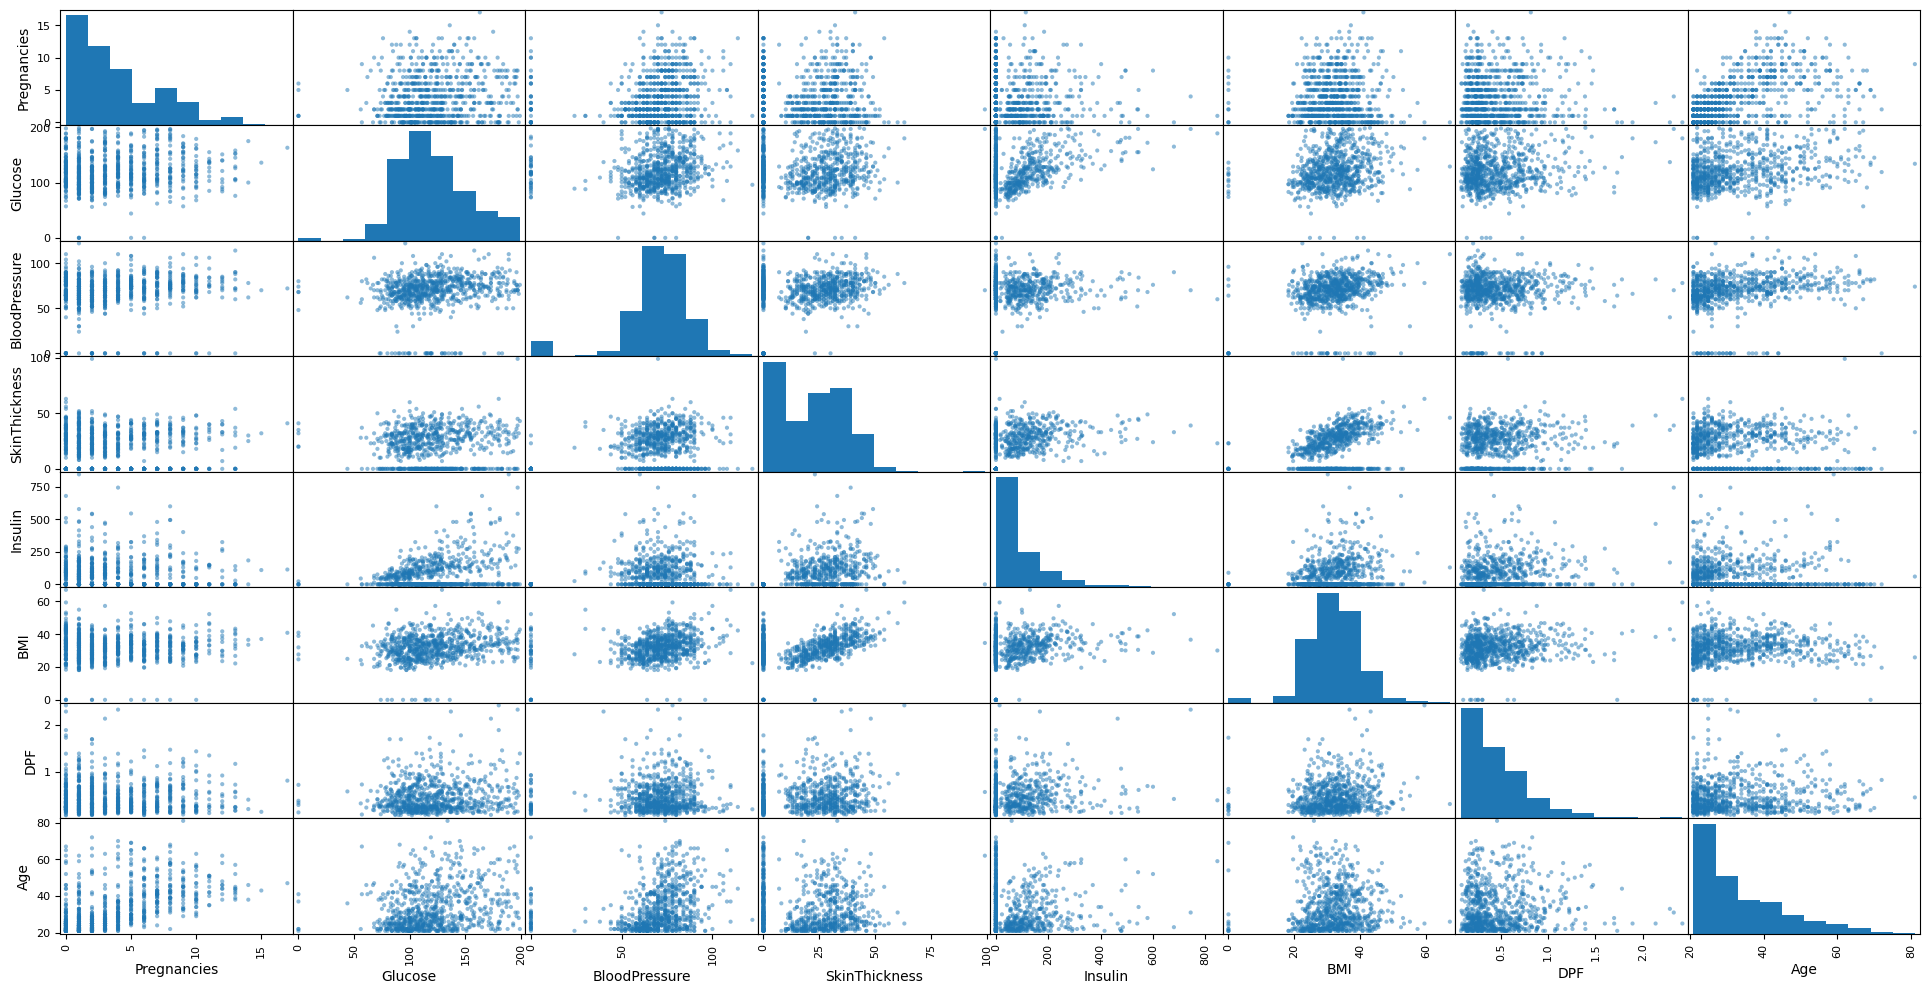

In [13]:
pd.plotting.scatter_matrix(df_dataset[cols], figsize=(24, 12));

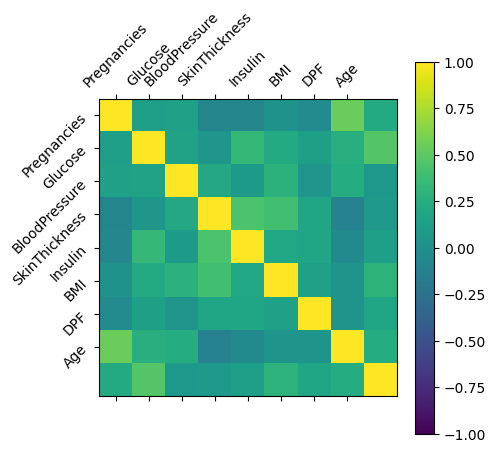

<Figure size 640x480 with 0 Axes>

In [14]:
plt.matshow(corr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(len(df_dataset.columns[:-1])), rotation=45)
plt.yticks(np.arange(len(df_dataset.columns[:-1])), rotation=45)
plt.gca().set_xticklabels(list(df_dataset.columns[:-1]))
plt.gca().set_yticklabels(list(df_dataset.columns[:-1]))
plt.show()
plt.savefig('matrix_corr.png')


## 4. Chuẩn bị dữ liệu (Prepare Data)

### 4.1. Làm sạch dữ liệu (Data Cleaning)

#### (1) **Tạo bảng dữ liệu làm sạch**


In [15]:
df_rem = df_dataset.copy()

#### (2) **Xử lý giá trị rỗng, không hợp lệ**
Như đã nêu ở trên, chúng ta có thể loại bỏ các hàng có giá trị bằng 0 trong các cột **Glucose, BloodPressure và BMI**.

In [29]:
### Tạo DataFrame mới, loại bỏ các hàng không mong muốn
df_rem = df_dataset[(df_dataset["Glucose"] != 0) & (df_dataset["BloodPressure"] != 0) & (df_dataset["BMI"] != 0)]

### Kiểm tra DataFrame mới
print("Size of dataframe:", df_rem.shape)
df_rem.head()


Size of dataframe: (724, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [30]:
### Kiểm tra giá trị nhỏ nhất trong df_rem
df_rem.describe().loc["min"]

,min
Pregnancies,0.000
Glucose,44.000
BloodPressure,24.000
SkinThickness,0.000
Insulin,0.000
BMI,18.200
DPF,0.078
Age,21.000
Outcome,0.000


+ Có 44 dòng có giá trị 0 ở cột Glucose, BloodPressure và BMI được loại bỏ.

**Impute (Điền giá trị thay thế)**

Vì có nhiều hàng dữ liệu với giá trị bằng 0 ở cột **SkinThickness**, chúng ta sẽ sử dụng Hồi quy tuyến tính (**Linear Regression**) để ước lượng và thay thế những giá trị này thành các giá trị khác không bằng 0.

In [31]:
# Impute cho SkinThickness bằng Linear Regression
# 1. Tách dữ liệu có và không có SkinThickness
df_impute = df_rem[df_rem["SkinThickness"] != 0].copy()
df_0 = df_rem[df_rem["SkinThickness"] == 0].copy()

# 2. Huấn luyện Linear Regression với dữ liệu hợp lệ
linreg = LinearRegression()
linreg.fit(
    df_impute.drop(["SkinThickness", "Outcome"], axis=1),
    df_impute["SkinThickness"]
)

# 3. Dự đoán và thay thế giá trị cho những hàng có SkinThickness = 0
df_0.loc[:, "SkinThickness"] = linreg.predict(
    df_0.drop(["SkinThickness", "Outcome"], axis=1)
)

# 4. Gộp lại hai phần dữ liệu
df_impute = pd.concat([df_impute, df_0], axis=0)

# 5. Thống kê kết quả
print(df_impute.describe())


       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   724.000000  724.000000     724.000000     724.000000  724.000000   
mean      3.866022  121.882597      72.400552      29.024005   84.494475   
std       3.362803   30.750030      12.379870       9.683955  117.016513   
min       0.000000   44.000000      24.000000       7.000000    0.000000   
25%       1.000000   99.750000      64.000000      22.014105    0.000000   
50%       3.000000  117.000000      72.000000      29.000000   48.000000   
75%       6.000000  142.000000      80.000000      35.004675  130.500000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI         DPF         Age     Outcome  
count  724.000000  724.000000  724.000000  724.000000  
mean    32.467127    0.474765   33.350829    0.343923  
std      6.888941    0.332315   11.765393    0.475344  
min     18.200000    0.078000   21.000000    0.000000  
25%     27.500000    0.245000   24.

/tmp/ipython-input-441784024.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[21.98604143 22.14675622 33.32664506 36.15735053 27.16982153 26.1578876
 33.25667971 38.48706598 37.47001538 30.88635361 15.76845009 31.01140373
 37.48701428 25.96992562 26.66326265 38.37056826 30.69179673 20.99738705
 30.47733841 40.35958133 41.32885631 29.04230883 45.20598628 14.2897968
 23.27617911 36.36048056 22.46284304 17.7347317  35.01870165 17.25357483
 29.27478869 30.57159115 31.16856821 29.42712744 26.86502221 28.50348589
 26.46416385 30.9893962  27.367251   19.91141155 30.26061987 33.5717952
 19.23238818 46.56177728 27.93997905 26.63347526 28.19922342 27.41037442
 28.11488333 42.94045249 36.28908684 19.37853745 22.46486236 25.3554059
 18.33855457 28.54604547 19.76505673 36.02142275 36.2109299  35.03017586
 31.55530708 30.83518454 39.74257661 31.39163303 40.42338605 14.27448076
 22.10338191 29.24317423 29.21654946 24.0649132

### 4.2. Biến đổi dữ liệu (Data Transforms)

#### (1) Chuẩn hóa dữ liệu (Standard Scaler)

In [50]:
scale_columns = ["Pregnancies", "Glucose","BloodPressure","SkinThickness", "Insulin", "BMI", "DPF", "Age"]
#Khởi tạo Standard Scaler
scaler = StandardScaler()

#Fit scaler với tập huấn luyện
scaler.fit(df_impute[scale_columns])

df_impute[scale_columns] = scaler.transform(df_impute[scale_columns])

df_impute



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.635022,0.849933,-0.032378,0.617529,-0.722572,0.164562,0.458421,1.416075,1
1,-0.852861,-1.200262,-0.517370,-0.002481,-0.722572,-0.852262,-0.372691,-0.199947,0
3,-0.852861,-1.070091,-0.517370,-0.622490,0.081288,-0.634371,-0.926765,-1.050485,0
4,-1.150438,0.491962,-2.619006,0.617529,0.714115,1.544537,5.460146,-0.029839,1
6,-0.257708,-1.428061,-1.810684,0.307524,0.029978,-0.213116,-0.682852,-0.625216,1
...,...,...,...,...,...,...,...,...,...
757,-1.150438,0.036363,-0.032378,0.530361,-0.722572,0.556765,-0.652739,1.586183,1
758,-0.852861,-0.516864,0.290951,0.387986,-0.722572,0.731078,-0.836427,-0.625216,0
759,0.635022,2.216729,1.584265,0.735369,-0.722572,0.440557,-0.592514,2.776936,1
762,1.527752,-1.070091,-0.840699,-0.993503,-0.722572,-1.447830,-1.002047,-0.029839,0


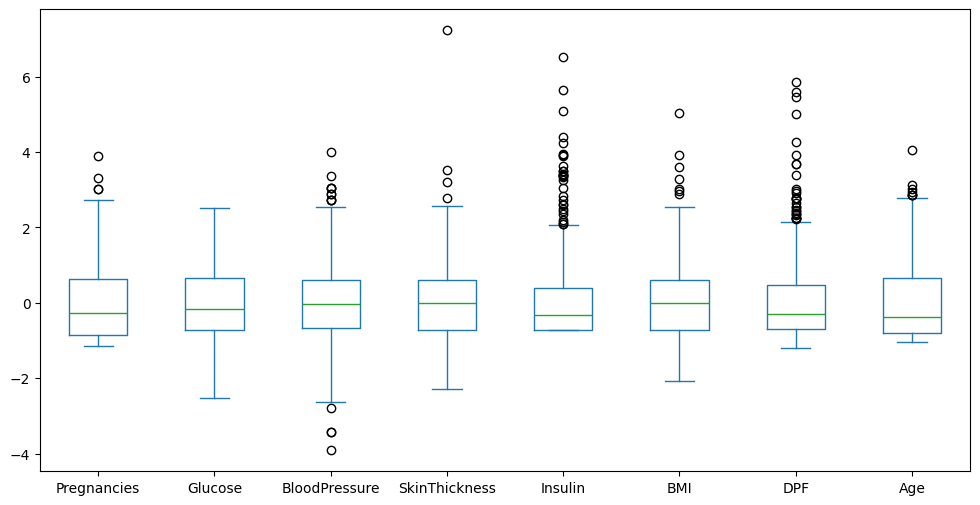

In [51]:
df_impute[scale_columns].plot(kind="box", figsize=(12,6));

In [53]:
correlations = df_impute.corr(method='pearson')
print(correlations)

               Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Pregnancies       1.000000  0.134915       0.209668       0.105720 -0.080059   
Glucose           0.134915  1.000000       0.223331       0.234741  0.337896   
BloodPressure     0.209668  0.223331       1.000000       0.234792 -0.046856   
SkinThickness     0.105720  0.234741       0.234792       1.000000  0.117738   
Insulin          -0.080059  0.337896      -0.046856       0.117738  1.000000   
BMI               0.012342  0.223276       0.287403       0.698708  0.191831   
DPF              -0.025996  0.136630      -0.000075       0.123243  0.182656   
Age               0.557066  0.263560       0.324897       0.148332 -0.049412   
Outcome           0.224417  0.488384       0.166703       0.269874  0.145488   

                    BMI       DPF       Age   Outcome  
Pregnancies    0.012342 -0.025996  0.557066  0.224417  
Glucose        0.223276  0.136630  0.263560  0.488384  
BloodPressure  0.287403 -0.0000

#### (2) Chia dữ liệu thực nghiệm
+ Chuyển đổi dữ liệu sang dạng numpy với phần Input (X_data), Output (y_data)
+ Chia dữ liệu thành tập train/test (tỷ lệ 70/30)
+ Lưu tất cả thông tin để chuẩn bị chạy thuật toán

In [56]:
### Tách biến dự đoán (predictors) và biến mục tiêu (target)
X = df_impute.drop(["Outcome"], axis=1)
y = df_impute["Outcome"]

print("Size of x (predictors):\t{}\nSize of y (target):\t{}".format(X.shape, y.shape))
print(X[:20])
print(y[:20])

Size of x (predictors):	(724, 8)
Size of y (target):	(724,)
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.635022  0.849933      -0.032378       0.617529 -0.722572  0.164562   
1     -0.852861 -1.200262      -0.517370      -0.002481 -0.722572 -0.852262   
3     -0.852861 -1.070091      -0.517370      -0.622490  0.081288 -0.634371   
4     -1.150438  0.491962      -2.619006       0.617529  0.714115  1.544537   
6     -0.257708 -1.428061      -1.810684       0.307524  0.029978 -0.213116   
8     -0.555284  2.444529      -0.194042       1.650879  3.921006 -0.285746   
13    -0.852861  2.184187      -1.002363      -0.622490  6.512175 -0.343850   
14     0.337445  1.435703      -0.032378      -1.035830  0.773977 -0.968471   
16    -1.150438 -0.126350       0.937608       1.857549  1.244321  1.936740   
18    -0.852861 -0.614492      -3.427327       0.927534 -0.012780  1.573589   
19    -0.852861 -0.223979      -0.194042       0.100854  0.098392  0.30

In [48]:
# Chia tập dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=1
)
# Kiểm tra kích thước để chắc chắn mọi thứ đúng
print("Kích thước X_train: {} \t Kích thước X_test: {} \nKích thước y_train: {} \t Kích thước y_test: {}".format(
    X_train.shape, X_test.shape, y_train.shape, y_test.shape))
print(f'+ Train/Test: Train Ratio = {len(X_train)/len(X)}')
print(f'+ Train: shape={X_train.shape}\nInput = \n{X_train[:5]}\nOutput = {y_train[:5]}')
print(f'+ Test: shape={X_test.shape}\nInput = \n{X_test[:5]}\nOutput = {y_test[:5]}')

Kích thước X_train: (506, 8) 	 Kích thước X_test: (218, 8) 
Kích thước y_train: (506,) 	 Kích thước y_test: (218,)
+ Train/Test: Train Ratio = 0.6988950276243094
+ Train: shape=(506, 8)
Input = 
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
379            0       93            100      39.000000       72  43.4  1.021   
135            2      125             60      20.000000      140  33.8  0.088   
273            1       71             78      50.000000       45  33.2  0.422   
537            0       57             60      20.300778        0  21.7  0.735   
665            1      112             80      45.000000      132  34.8  0.217   

     Age  
379   35  
135   31  
273   21  
537   67  
665   24  
Output = 379    0
135    0
273    0
537    0
665    0
Name: Outcome, dtype: int64
+ Test: shape=(218, 8)
Input = 
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI    DPF  \
103            1       81             72      18.000000  

In [64]:
# Lưu thông tin
save_dir = "exps/pima-indians"
if os.path.exists(save_dir) == False: os.makedirs(save_dir)

# Save training data
np.savez(f'{save_dir}/data.npz', X_train=X_train, X_test=X_test, y_train=y_test, y_test=y_test)
# Save cleaning data
df_impute.to_excel(f'{save_dir}/df_impute.xlsx', index=False)
# Save encoders - Removed as class_encoder is not defined
# joblib.dump(class_encoder, f'{save_dir}/class_encoder.joblib')

os.listdir(save_dir)

['data.npz', 'df_impute.xlsx']

In [65]:
# Kiểm tra phục hồi dữ liệu
dict(np.load(f'{save_dir}/data.npz')).keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test'])

In [66]:
pd.read_excel(f'{save_dir}/df_impute.xlsx')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.635022,0.849933,-0.032378,0.617529,-0.722572,0.164562,0.458421,1.416075,1
1,-0.852861,-1.200262,-0.517370,-0.002481,-0.722572,-0.852262,-0.372691,-0.199947,0
2,-0.852861,-1.070091,-0.517370,-0.622490,0.081288,-0.634371,-0.926765,-1.050485,0
3,-1.150438,0.491962,-2.619006,0.617529,0.714115,1.544537,5.460146,-0.029839,1
4,-0.257708,-1.428061,-1.810684,0.307524,0.029978,-0.213116,-0.682852,-0.625216,1
...,...,...,...,...,...,...,...,...,...
719,-1.150438,0.036363,-0.032378,0.530361,-0.722572,0.556765,-0.652739,1.586183,1
720,-0.852861,-0.516864,0.290951,0.387986,-0.722572,0.731078,-0.836427,-0.625216,0
721,0.635022,2.216729,1.584265,0.735369,-0.722572,0.440557,-0.592514,2.776936,1
722,1.527752,-1.070091,-0.840699,-0.993503,-0.722572,-1.447830,-1.002047,-0.029839,0


# **Kết thúc**